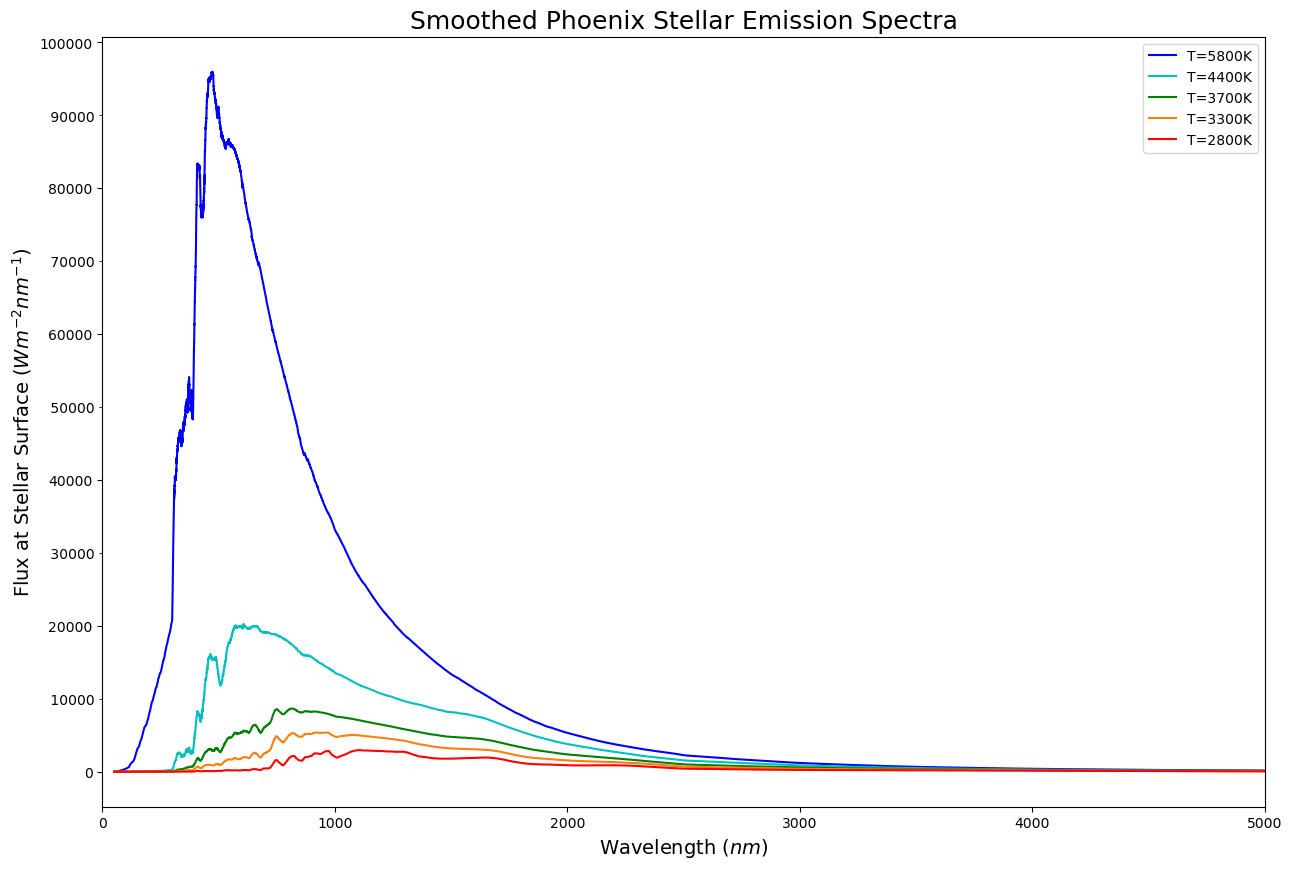

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
from matplotlib.ticker import (MultipleLocator, #major/minor ticks
                               FormatStrFormatter,
                               AutoMinorLocator)

#Function to smooth the spectrum
def movingaverage(interval, window_size):
    window= np.ones(int(window_size))/float(window_size)
    return np.convolve(interval, window, 'same')

def reduce_by_interpolation(spectrum, newsize=1000):
    '''
    Reduces the resolution of the spectrum, so that the size is less than 1000 points, by interpolating
    then resampling the data.
    Args:
        spectrum : the spectral singal, in the standard two-column format
        newsize : the size to resample to (default 1000), if spectrum is smaller than this
            will return the original array
    Returns:
        A reduced spectrum.
    '''
    rows, cols = spectrum.shape
    if rows <= newsize:
        print("Warning: Spectral data already less than "+str(newsize)+' data points, no reduction performed')
        return spectrum
    else:
        l1 = np.min(spectrum[:,0])
        l2 = np.max(spectrum[:,0])
        xnew = np.linspace(l1, l2, newsize)
        ynew = np.interp(xnew, spectrum[:,0], spectrum[:,1])
        newspectrum = np.zeros((newsize, 2))
        newspectrum[:,0] = xnew
        newspectrum[:,1] = ynew
        return newspectrum


#To convert angstroms to nm
AngstromTonm = 0.1

#To convert ergs-1cm-2cm-1 to Wm-2nm-1 = 10^-7 (erg s-1 to W)  x 10^4 (cm-2 to m-2) x 10^-7 (cm-1 to m-1) = x10^-10

#PHOENIX: Load the wavelength and 5 Phoenix files
wavelengths_data = fits.getdata("WAVE_PHOENIX-ACES-AGSS-COND-2011.fits")

Star5800_data = fits.getdata("lte05800-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
maxVal1 = 0.0
maxVal2 = 0.0
Rsol = 6.96e8 #metres
au = 1.5e11 #metres 

Star4400_data = fits.getdata("lte04400-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
Star3700_data = fits.getdata("lte03700-4.50-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
Star3300_data = fits.getdata("lte03300-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")
Star2800_data = fits.getdata("lte02800-5.00-0.0.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits")

#Do the smoothing
smoothed5800 = movingaverage(Star5800_data, 30000)
smoothed4400 = movingaverage(Star4400_data, 30000)
smoothed3700 = movingaverage(Star3700_data, 30000)
smoothed3300 = movingaverage(Star3300_data, 30000)
smoothed2800 = movingaverage(Star2800_data, 30000)

reduced5800=reduce_by_interpolation(np.c_[wavelengths_data,smoothed5800], newsize=4000)
reduced4400=reduce_by_interpolation(np.c_[wavelengths_data,smoothed4400], newsize=4000)
reduced3700=reduce_by_interpolation(np.c_[wavelengths_data,smoothed3700], newsize=4000)
reduced3300=reduce_by_interpolation(np.c_[wavelengths_data,smoothed3300], newsize=4000)
reduced2800=reduce_by_interpolation(np.c_[wavelengths_data,smoothed2800], newsize=4000)

#Do the conversions of x and y axes
np.savetxt("5800K_SmoothedSpectrum30000_PHOENIX.txt", np.c_[reduced5800[:,0]*AngstromTonm, reduced5800[:,1]*1.0e-10])
np.savetxt("4400K_SmoothedSpectrum30000_PHOENIX.txt", np.c_[reduced4400[:,0]*AngstromTonm, reduced4400[:,1]*1.0e-10])
np.savetxt("3700K_SmoothedSpectrum30000_PHOENIX.txt", np.c_[reduced3700[:,0]*AngstromTonm, reduced3700[:,1]*1.0e-10])
np.savetxt("3300K_SmoothedSpectrum30000_PHOENIX.txt", np.c_[reduced3300[:,0]*AngstromTonm, reduced3300[:,1]*1.0e-10])
np.savetxt("2800K_SmoothedSpectrum30000_PHOENIX.txt", np.c_[reduced2800[:,0]*AngstromTonm, reduced2800[:,1]*1.0e-10])


#Plot the spectral models
fig, ax = plt.subplots(figsize=(15, 10)) 

ax.plot(wavelengths_data*AngstromTonm, smoothed5800*1.0e-10, linestyle='-',color='b', label="T=5800K")
ax.plot(wavelengths_data*AngstromTonm, smoothed4400*1.0e-10, linestyle='-',color='c', label="T=4400K")
ax.plot(wavelengths_data*AngstromTonm, smoothed3700*1.0e-10, linestyle='-',color='g', label="T=3700K")
ax.plot(wavelengths_data*AngstromTonm, smoothed3300*1.0e-10, linestyle='-',color='tab:orange', label="T=3300K")
ax.plot(wavelengths_data*AngstromTonm, smoothed2800*1.0e-10, linestyle='-',color='r', label="T=2800K")

ax.set_title('Smoothed Phoenix Stellar Emission Spectra', fontsize=18) 
ax.set_ylabel('Flux at Stellar Surface ($Wm^{-2}nm^{-1}$)', fontsize=14)
ax.set_xlabel('Wavelength ($nm$)', fontsize=14) 

ax.set_xlim(0, 5.0e+03)
ax.set_ylim
ax.yaxis.set_minor_locator(MultipleLocator(10000))
ax.yaxis.set_minor_formatter(FormatStrFormatter('% 1.0f'))

plt.legend()
plt.savefig('Smoothed_Phoenix_Stellar_Emission_Spectra.png')
plt.show()

In [4]:
# Benchmarking to Solar Luminosity Method 1 

Rsolal = 6.96e8
pi = 3.1415926

##Trap method 
print('Trapezium Integration:', '{:.3g}'.format(np.trapz(smoothed5800*1.0e-10, wavelengths_data*AngstromTonm)), 'W/m2')

#Calculate Luminosity
Solar_Luminosity = 4.0*pi*(Rsolal**2)*np.trapz(smoothed5800*1.0e-10, wavelengths_data*AngstromTonm)
print('Solar Luminosity:', '{:.3g}'.format(Solar_Luminosity), 'W')
print('where target Solar Luminosity:', '3.84x10^26', 'W')

Trapezium Integration: 6.4e+07 W/m2
Solar Luminosity: 3.89e+26 W
where target Solar Luminosity: 3.84x10^26 W


In [5]:
# Benchmarking to Solar Luminosity Method 2

res = 1

spec_1 = []  
spec_2 = [] 
counter = 0 

fin = open('5800K_SmoothedSpectrum30000_PHOENIX.txt', 'r') 
#fout = open('Benchmarking_I_5800K.txt','w') 

for line in fin: 
    line = line.rstrip() 
    elements = line.split(' ') 
    wavelength = float(elements[0])
    intensity = float(elements[1])
    counter = counter + 1 
    
    if counter%res == 0: 
        spec_1.append(wavelength) 
        spec_2.append(intensity) 
        #fout.write(str(wavelength)+'\t'+str(intensity)+'\n')
          
#Bin method
integral = 0.0 
for i in range(0, len(spec_2)-1): 
    binwidth = spec_1[i+1] - spec_1[i] 
    integral = integral + spec_2[i]*binwidth
print('Bin Integration:', '{:.3g}'.format(integral), 'W/m2')

#Calculate Luminosity
Luminosity = 4.0*pi*(Rsolal**2)*integral
print('Luminosity:', '{:.3g}'.format(Luminosity), 'W')
print('where target Luminosity:', '3.84x10^26', 'W')

Bin Integration: 6.4e+07 W/m2
Luminosity: 3.89e+26 W
where target Luminosity: 3.84x10^26 W
